### Antoine EDY
# Natural Language Processing (COMM061) - Coursework

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import nltk
from torch.utils.tensorboard import SummaryWriter

In [2]:
dataset = load_dataset("surrey-nlp/PLOD-CW")

In [3]:
def the_preprocess(df):
    df = pd.DataFrame(df)
    # make everything lowercase
    #df["tokens"] = df["tokens"].apply(lambda x: [i.lower() for i in x])
    # lematize
    #lematizer = nltk.WordNetLemmatizer()
    #df["tokens"] = df["tokens"].apply(lambda x: [lematizer.lemmatize(i) for i in x])
    #stemming
    stemmer = nltk.PorterStemmer()
    df["tokens"] = df["tokens"].apply(lambda x: [stemmer.stem(i) for i in x])

    return df

train_dataset = the_preprocess(dataset["train"])
test_dataset = the_preprocess(dataset["test"])
val_dataset = the_preprocess(dataset["validation"])

In [4]:
lematizer = nltk.WordNetLemmatizer()
sentence = "The striped bats are hanging on their feet for best"
sentence = sentence.split()
sentence = [lematizer.lemmatize(i) for i in sentence]
print(sentence)

['The', 'striped', 'bat', 'are', 'hanging', 'on', 'their', 'foot', 'for', 'best']


In [5]:
stemmer = nltk.PorterStemmer()
sentence = "The striped bats are hanging on their feet for best"
sentence = sentence.split()
sentence = [lematizer.lemmatize(i) for i in sentence]
sentence = [stemmer.stem(i) for i in sentence]
print(sentence)

['the', 'stripe', 'bat', 'are', 'hang', 'on', 'their', 'foot', 'for', 'best']


In [6]:
TEXT2ID = {
    "B-O": 0,
    "B-AC": 1,
    "PAD": 2,
    "B-LF": 3,
    "I-LF": 4,
}
ID2TEXT = {v: k for k, v in TEXT2ID.items()}

print(f"TEXT2ID: {TEXT2ID}\nID2TEXT: {ID2TEXT}\n")

def preprocess(df):
    df = df.drop(columns=['pos_tags'])
    df = df.rename(columns={"ner_tags": "labels"})
    df["ids"] = df["labels"].apply(lambda x: [TEXT2ID[i] for i in x])
    df["sentences"] = df["tokens"].apply(lambda x: " ".join(x))

    return df


train_dataset = preprocess(train_dataset)
test_dataset = preprocess(test_dataset)
val_dataset = preprocess(val_dataset)

train_dataset.info()


# Here the exploration to add at the end of the work.

TEXT2ID: {'B-O': 0, 'B-AC': 1, 'PAD': 2, 'B-LF': 3, 'I-LF': 4}
ID2TEXT: {0: 'B-O', 1: 'B-AC', 2: 'PAD', 3: 'B-LF', 4: 'I-LF'}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tokens     1072 non-null   object
 1   labels     1072 non-null   object
 2   ids        1072 non-null   object
 3   sentences  1072 non-null   object
dtypes: object(4)
memory usage: 33.6+ KB


In [7]:
train_dataset.head()

,tokens,labels,ids,sentences
0,"[for, thi, purpos, the, gothenburg, young, per...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I...","[0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0, 0]",for thi purpos the gothenburg young person emp...
1,"[the, follow, physiolog, trait, were, measur, ...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, ...",the follow physiolog trait were measur : stoma...
2,"[minor, h, antigen, alloimmun, respons, readil...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, ...",minor h antigen alloimmun respons readili occu...
3,"[epi, =, echo, planar, imag, .]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]","[1, 0, 3, 4, 4, 0]",epi = echo planar imag .
4,"[furthermor, ,, eno, -, deriv, no, s, -, nitro...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","furthermor , eno - deriv no s - nitrosyl β - a..."


In [8]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

1072
126
153


In [9]:
train_dataset.head()

,tokens,labels,ids,sentences
0,"[for, thi, purpos, the, gothenburg, young, per...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I...","[0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0, 0]",for thi purpos the gothenburg young person emp...
1,"[the, follow, physiolog, trait, were, measur, ...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, ...",the follow physiolog trait were measur : stoma...
2,"[minor, h, antigen, alloimmun, respons, readil...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, ...",minor h antigen alloimmun respons readili occu...
3,"[epi, =, echo, planar, imag, .]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]","[1, 0, 3, 4, 4, 0]",epi = echo planar imag .
4,"[furthermor, ,, eno, -, deriv, no, s, -, nitro...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","furthermor , eno - deriv no s - nitrosyl β - a..."


In [10]:
from torchtext.data import Field, Dataset, Example

text_field = Field(sequential=True, tokenize=lambda x:x, include_lengths=True) # Default behaviour is to tokenize by splitting
label_field = Field(sequential=True, tokenize=lambda x:x, is_target=True)

fields = {
    'sentences': ('text', text_field),
    'ids': ('label', label_field)
}

def read_data(df):
    examples = []
    fields = {'sentence_labels': ('labels', label_field),
              'sentence_tokens': ('text', text_field)}
    
    for i in range(len(df)):
        tokens = df['tokens'][i]
        labels = df['labels'][i]
        
        e = Example.fromdict({"sentence_labels": labels, "sentence_tokens": tokens},
                             fields=fields)
        examples.append(e)
    
    return Dataset(examples, fields=[('labels', label_field), ('text', text_field)])


train_data = read_data(train_dataset)
val_data = read_data(val_dataset)
test_data = read_data(test_dataset)

print(train_data.fields)
print(train_data[0].text)
print(train_data[0].labels)

print("Train:", len(train_data))
print("Dev:", len(val_data))
print("Test:", len(test_data))

{'labels': <torchtext.data.field.Field object at 0x176264c40>, 'text': <torchtext.data.field.Field object at 0x107985e10>}
['for', 'thi', 'purpos', 'the', 'gothenburg', 'young', 'person', 'empower', 'scale', '(', 'gype', ')', 'wa', 'develop', '.']
['B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O']
Train: 1072
Dev: 126
Test: 153


In [11]:
VOCAB_SIZE = 20000

text_field.build_vocab(train_data, max_size=VOCAB_SIZE)
label_field.build_vocab(train_data)

In [12]:
from torchtext.data import BucketIterator

BATCH_SIZE = 32
train_iter = BucketIterator(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, 
                            sort_key=lambda x: len(x.text), sort_within_batch=True)
val_iter = BucketIterator(dataset=val_data, batch_size=BATCH_SIZE, 
                          sort_key=lambda x: len(x.text), sort_within_batch=True)
test_iter = BucketIterator(dataset=test_data, batch_size=BATCH_SIZE, 
                           sort_key=lambda x: len(x.text), sort_within_batch=True)

In [13]:
import random
import os
import numpy as np

emb = 'fasttext'

if emb == 'fasttext':

    EMBEDDING_PATH = "/Users/antoineedy/Documents/MScAI/Semester2/NLP/Coursework/code/data/cc.en.300.vec"

    def load_embeddings(path):
        """ Load the FastText embeddings from the embedding file. """
        print("Loading pre-trained embeddings")
        
        embeddings = {}
        with open(path) as i:
            for line in i:
                if len(line) > 2: 
                    line = line.strip().split()
                    word = line[0]
                    embedding = np.array(line[1:])
                    embeddings[word] = embedding
        
        return embeddings
        

    def initialize_embeddings(embeddings, vocabulary):
        """ Use the pre-trained embeddings to initialize an embedding matrix. """
        print("Initializing embedding matrix")
        embedding_size = len(embeddings["."])
        embedding_matrix = np.zeros((len(vocabulary), embedding_size), dtype=np.float32)
                                    
        for idx, word in enumerate(vocabulary.itos): 
            if word in embeddings:
                embedding_matrix[idx,:] = embeddings[word]
                
        return embedding_matrix

    embeddings = load_embeddings(EMBEDDING_PATH)
    embedding_matrix = initialize_embeddings(embeddings, text_field.vocab)
    embedding_matrix = torch.from_numpy(embedding_matrix)
    print(embedding_matrix.shape)

elif emb == 'glove':

    EMBEDDING_PATH = "data/glove.6B.300d.txt"

    def load_embeddings(path):
        """ Load the FastText embeddings from the embedding file. """
        print("Loading pre-trained embeddings")
        
        embeddings = {}
        with open(path) as i:
            for line in i:
                if len(line) > 2: 
                    line = line.strip().split()
                    word = line[0]
                    embedding = np.array(line[1:])
                    embeddings[word] = embedding
        
        return embeddings
        

    def initialize_embeddings(embeddings, vocabulary):
        """ Use the pre-trained embeddings to initialize an embedding matrix. """
        print("Initializing embedding matrix")
        embedding_size = len(embeddings["."])
        embedding_matrix = np.zeros((len(vocabulary), embedding_size), dtype=np.float32)
                                    
        for idx, word in enumerate(vocabulary.itos): 
            if word in embeddings:
                embedding_matrix[idx,:] = embeddings[word]
                
        return embedding_matrix

    embeddings = load_embeddings(EMBEDDING_PATH)
    embedding_matrix = initialize_embeddings(embeddings, text_field.vocab)
    embedding_matrix = torch.from_numpy(embedding_matrix)
    print(embedding_matrix.shape)


elif emb == 'word2vec':
    import gensim
    model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)
    em = []
    for word in text_field.vocab.itos:
        if word in model:
            em.append(model.get_vector(word))
        else:
            em.append(np.zeros(300))
    em = np.array(em)
    embedding_matrix = torch.tensor(em, dtype=torch.float32)
    print(embedding_matrix.shape)

Loading pre-trained embeddings
Initializing embedding matrix
torch.Size([6853, 300])


In [14]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTMTagger, self).__init__()
        
        # 1. Embedding Layer
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)
        
        # 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=1)
        
        # 3. Optional dropout layer
        self.dropout_layer = nn.Dropout(p=0.5)

        # 4. Dense Layer
        self.hidden2tag = nn.Linear(2*hidden_dim, output_size)
        
    def forward(self, batch_text, batch_lengths):

        embeddings = self.embeddings(batch_text)
        
        packed_seqs = pack_padded_sequence(embeddings, batch_lengths)
        lstm_output, _ = self.lstm(packed_seqs)
        lstm_output, _ = pad_packed_sequence(lstm_output)
        lstm_output = self.dropout_layer(lstm_output)
        
        logits = self.hidden2tag(lstm_output)
        return logits

In [15]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, classification_report

def remove_predictions_for_masked_items(predicted_labels, correct_labels): 

    predicted_labels_without_mask = []
    correct_labels_without_mask = []
        
    for p, c in zip(predicted_labels, correct_labels):
        if c > 1:
            predicted_labels_without_mask.append(p)
            correct_labels_without_mask.append(c)
            
    return predicted_labels_without_mask, correct_labels_without_mask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES}: {label_field.vocab.itos}")

def train(model, train_iter, dev_iter, batch_size, max_epochs, num_batches, patience, output_path):
    writer = SummaryWriter()
    # add weight to indexes 3, 4, 5
    w = [0, 0, 0.0443, 0.6259, 1.0000, 0.4525]
    class_weights = torch.tensor(w).to(device)
    criterion = nn.CrossEntropyLoss(weight = class_weights, ignore_index=1)  # we mask the <pad> labels
    optimizer = optim.Adam(model.parameters())

    train_f_score_history = []
    dev_f_score_history = []
    no_improvement = 0
    for epoch in range(max_epochs):

        total_loss = 0
        predictions, correct = [], []
        for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):
            optimizer.zero_grad()
            
            text_length, cur_batch_size = batch.text[0].shape
            
            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size*text_length)
            
            loss = criterion(pred, gold)
            
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, pred_indices = torch.max(pred, 1)
            
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        train_scores = precision_recall_fscore_support(correct, predictions, average="micro")
        train_f_score_history.append(train_scores[2])
            
        print("Total training loss:", total_loss)
        print("Training performance:", train_scores)

        #tensorboard
        writer.add_scalar('train/loss', total_loss, epoch)
        writer.add_scalar('train/precision', train_scores[2], epoch)

        
        total_loss = 0
        predictions, correct = [], []
        for batch in dev_iter:

            text_length, cur_batch_size = batch.text[0].shape

            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size * text_length)
            loss = criterion(pred, gold)
            total_loss += loss.item()

            _, pred_indices = torch.max(pred, 1)
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        dev_scores = precision_recall_fscore_support(correct, predictions, average="micro")
            
        print("Total development loss:", total_loss)
        print("Development performance:", dev_scores)

        writer.add_scalar('val/loss', total_loss, epoch)
        writer.add_scalar('val/precision', dev_scores[2], epoch)

        labels = label_field.vocab.itos[2:]
        labels = sorted(labels, key=lambda x: x.split("-")[-1])
        label_idxs = [label_field.vocab.stoi[l] for l in labels]

        cr = classification_report(correct, predictions, labels = label_idxs, target_names=labels, output_dict=True)

        out = {}
        for key in cr.keys():
            if key == 'accuracy':
                out[key] = cr[key]
            else:
                for new_k in ['precision', 'recall', 'f1-score']:
                    out[key+'_'+new_k] = cr[key][new_k]
        
        for (key, value) in out.items():
            writer.add_scalar(f'test/{key}', value, epoch)
        
        dev_f = dev_scores[2]

        dev_f = out['macro avg_f1-score']

        if len(dev_f_score_history) > patience and dev_f < max(dev_f_score_history):
            no_improvement += 1

        elif len(dev_f_score_history) == 0 or dev_f > max(dev_f_score_history):
            print("Saving model.")
            torch.save(model, output_path)
            no_improvement = 0
            
        if no_improvement > patience:
            print("Macro average F1-score does not improve anymore. Stop training.")
            dev_f_score_history.append(dev_f)
            break
            
        dev_f_score_history.append(dev_f)
        
    return train_f_score_history, dev_f_score_history

Number of classes: 6: ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


In [16]:
def test(model, test_iter, batch_size, labels, target_names): 
    
    total_loss = 0
    predictions, correct = [], []
    for batch in test_iter:

        text_length, cur_batch_size = batch.text[0].shape

        pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
        gold = batch.labels.to(device).view(cur_batch_size * text_length)

        _, pred_indices = torch.max(pred, 1)
        predicted_labels = list(pred_indices.cpu().numpy())
        correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())

        predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, correct_labels)

        predictions += predicted_labels
        correct += correct_labels
    
    print(classification_report(correct, predictions, labels=labels, target_names=target_names))

In [17]:
import math

EMBEDDING_DIM = 300 #fasttext & word2vec & glove
# EMBEDDING_DIM = 768 #bert
HIDDEN_DIM = 256
NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES} : {label_field.vocab.itos}")
MAX_EPOCHS = 70
PATIENCE = 50
OUTPUT_PATH = "model_saves/bilstmtagger"
num_batches = math.ceil(len(train_data) / BATCH_SIZE)

tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES, embeddings=embedding_matrix)  # embeddings
# tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES)  # no embeddings

train_f, dev_f = train(tagger.to(device), train_iter, val_iter, BATCH_SIZE, MAX_EPOCHS, 
                       num_batches, PATIENCE, OUTPUT_PATH)

Number of classes: 6 : ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


Epoch 0: 100%|██████████| 34/34 [00:05<00:00,  6.43it/s]
/Users/antoineedy/Documents/MScAI/Semester2/NLP/Coursework/code/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/antoineedy/Documents/MScAI/Semester2/NLP/Coursework/code/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/antoineedy/Documents/MScAI/Semester2/NLP/Coursework/code/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

Total training loss: 43.544673800468445
Training performance: (0.272925, 0.272925, 0.272925, None)
Total development loss: 4.025841593742371
Development performance: (0.3262, 0.3262, 0.3262, None)
Saving model.


Epoch 1: 100%|██████████| 34/34 [00:04<00:00,  6.99it/s]


Total training loss: 25.28701537847519
Training performance: (0.630125, 0.630125, 0.630125, None)
Total development loss: 2.8286158442497253
Development performance: (0.6796, 0.6796, 0.6796, None)
Saving model.


Epoch 2: 100%|██████████| 34/34 [00:05<00:00,  6.79it/s]


Total training loss: 19.036820024251938
Training performance: (0.73015, 0.73015, 0.73015, None)
Total development loss: 2.380902200937271
Development performance: (0.7276, 0.7276, 0.7276, None)
Saving model.


Epoch 3: 100%|██████████| 34/34 [00:04<00:00,  6.99it/s]


Total training loss: 16.557820826768875
Training performance: (0.7637, 0.7637, 0.7637, None)
Total development loss: 2.18414643406868
Development performance: (0.7396, 0.7396, 0.7396, None)
Saving model.


Epoch 4: 100%|██████████| 34/34 [00:05<00:00,  6.56it/s]


Total training loss: 14.907436102628708
Training performance: (0.772225, 0.772225, 0.772225, None)
Total development loss: 2.007444143295288
Development performance: (0.7914, 0.7914, 0.7914, None)
Saving model.


Epoch 5: 100%|██████████| 34/34 [00:04<00:00,  6.96it/s]


Total training loss: 13.551283299922943
Training performance: (0.786075, 0.786075, 0.786075, None)
Total development loss: 2.0411206483840942
Development performance: (0.8536, 0.8536, 0.8536, None)
Saving model.


Epoch 6: 100%|██████████| 34/34 [00:05<00:00,  6.49it/s]


Total training loss: 13.026100680232048
Training performance: (0.8039, 0.8039, 0.8039, None)
Total development loss: 1.898217648267746
Development performance: (0.759, 0.759, 0.759, None)


Epoch 7: 100%|██████████| 34/34 [00:04<00:00,  6.88it/s]


Total training loss: 12.306011110544205
Training performance: (0.8001, 0.8001, 0.8001, None)
Total development loss: 1.7805124521255493
Development performance: (0.8, 0.8, 0.8, None)


Epoch 8: 100%|██████████| 34/34 [00:05<00:00,  6.60it/s]


Total training loss: 11.050172984600067
Training performance: (0.81525, 0.81525, 0.81525, None)
Total development loss: 2.2343502044677734
Development performance: (0.8774, 0.8774, 0.8774, None)
Saving model.


Epoch 9: 100%|██████████| 34/34 [00:05<00:00,  6.03it/s]


Total training loss: 11.276677906513214
Training performance: (0.81305, 0.81305, 0.81305, None)
Total development loss: 1.7469784021377563
Development performance: (0.8118, 0.8118, 0.8118, None)


Epoch 10: 100%|██████████| 34/34 [00:05<00:00,  6.17it/s]


Total training loss: 9.917598575353622
Training performance: (0.828475, 0.828475, 0.828475, None)
Total development loss: 1.7121853530406952
Development performance: (0.8186, 0.8186, 0.8186, None)


Epoch 11: 100%|██████████| 34/34 [00:05<00:00,  6.46it/s]


Total training loss: 9.730658009648323
Training performance: (0.83575, 0.83575, 0.83575, None)
Total development loss: 1.7318670451641083
Development performance: (0.8596, 0.8596, 0.8596, None)


Epoch 12: 100%|██████████| 34/34 [00:04<00:00,  6.83it/s]


Total training loss: 8.983672969043255
Training performance: (0.8376, 0.8376, 0.8376, None)
Total development loss: 1.6829150915145874
Development performance: (0.8284, 0.8284, 0.8284, None)


Epoch 13: 100%|██████████| 34/34 [00:05<00:00,  6.65it/s]


Total training loss: 8.563602238893509
Training performance: (0.854225, 0.854225, 0.854225, None)
Total development loss: 1.6135553121566772
Development performance: (0.812, 0.812, 0.812, None)


Epoch 14: 100%|██████████| 34/34 [00:04<00:00,  6.89it/s]


Total training loss: 7.808508947491646
Training performance: (0.8556, 0.8556, 0.8556, None)
Total development loss: 1.7100560367107391
Development performance: (0.8214, 0.8214, 0.8214, None)


Epoch 15: 100%|██████████| 34/34 [00:05<00:00,  6.69it/s]


Total training loss: 7.282718330621719
Training performance: (0.8637, 0.8637, 0.8637, None)
Total development loss: 1.7419190406799316
Development performance: (0.8224, 0.8224, 0.8224, None)


Epoch 16: 100%|██████████| 34/34 [00:05<00:00,  6.15it/s]


Total training loss: 7.048831291496754
Training performance: (0.8693, 0.8693, 0.8693, None)
Total development loss: 1.8299660682678223
Development performance: (0.8524, 0.8524, 0.8524, None)


Epoch 17: 100%|██████████| 34/34 [00:05<00:00,  6.42it/s]


Total training loss: 6.438984468579292
Training performance: (0.8784, 0.8784, 0.8784, None)
Total development loss: 1.7027674317359924
Development performance: (0.849, 0.849, 0.849, None)


Epoch 18: 100%|██████████| 34/34 [00:05<00:00,  6.72it/s]


Total training loss: 6.127263315021992
Training performance: (0.886275, 0.886275, 0.886275, None)
Total development loss: 1.805647999048233
Development performance: (0.8576, 0.8576, 0.8576, None)


Epoch 19: 100%|██████████| 34/34 [00:05<00:00,  6.57it/s]


Total training loss: 5.812493618577719
Training performance: (0.88575, 0.88575, 0.88575, None)
Total development loss: 1.7678218185901642
Development performance: (0.8634, 0.8634, 0.8634, None)


Epoch 20: 100%|██████████| 34/34 [00:05<00:00,  6.36it/s]


Total training loss: 5.398964527994394
Training performance: (0.891225, 0.891225, 0.891225, None)
Total development loss: 1.922515094280243
Development performance: (0.877, 0.877, 0.877, None)
Saving model.


Epoch 21: 100%|██████████| 34/34 [00:05<00:00,  6.36it/s]


Total training loss: 4.851199612021446
Training performance: (0.903325, 0.903325, 0.903325, None)
Total development loss: 1.775145262479782
Development performance: (0.8268, 0.8268, 0.8268, None)


Epoch 22: 100%|██████████| 34/34 [00:04<00:00,  7.01it/s]


Total training loss: 4.652754809707403
Training performance: (0.902975, 0.902975, 0.902975, None)
Total development loss: 1.9197914600372314
Development performance: (0.8516, 0.8516, 0.8516, None)


Epoch 23: 100%|██████████| 34/34 [00:04<00:00,  7.19it/s]


Total training loss: 4.46712227165699
Training performance: (0.904475, 0.904475, 0.904475, None)
Total development loss: 1.728092983365059
Development performance: (0.8572, 0.8572, 0.8572, None)


Epoch 24: 100%|██████████| 34/34 [00:04<00:00,  7.09it/s]


Total training loss: 3.984348341822624
Training performance: (0.915575, 0.915575, 0.915575, None)
Total development loss: 1.898751437664032
Development performance: (0.858, 0.858, 0.858, None)


Epoch 25: 100%|██████████| 34/34 [00:05<00:00,  6.72it/s]


Total training loss: 3.6048019230365753
Training performance: (0.921675, 0.921675, 0.921675, None)
Total development loss: 2.0324288606643677
Development performance: (0.866, 0.866, 0.866, None)


Epoch 26: 100%|██████████| 34/34 [00:04<00:00,  7.01it/s]


Total training loss: 3.6738815680146217
Training performance: (0.9202, 0.9202, 0.9202, None)
Total development loss: 2.0655617117881775
Development performance: (0.8708, 0.8708, 0.8708, None)


Epoch 27: 100%|██████████| 34/34 [00:05<00:00,  6.69it/s]


Total training loss: 3.604207307100296
Training performance: (0.92425, 0.92425, 0.92425, None)
Total development loss: 2.096924990415573
Development performance: (0.8768, 0.8768, 0.8768, None)
Saving model.


Epoch 28: 100%|██████████| 34/34 [00:05<00:00,  6.53it/s]


Total training loss: 3.0749464258551598
Training performance: (0.9304, 0.9304, 0.9304, None)
Total development loss: 2.329009085893631
Development performance: (0.8902, 0.8902, 0.8902, None)
Saving model.


Epoch 29: 100%|██████████| 34/34 [00:05<00:00,  6.70it/s]


Total training loss: 2.6902157552540302
Training performance: (0.936475, 0.936475, 0.936475, None)
Total development loss: 2.416371464729309
Development performance: (0.8878, 0.8878, 0.8878, None)


Epoch 30: 100%|██████████| 34/34 [00:04<00:00,  7.36it/s]


Total training loss: 2.363091627135873
Training performance: (0.945075, 0.945075, 0.945075, None)
Total development loss: 2.5371946692466736
Development performance: (0.8886, 0.8886, 0.8886, None)


Epoch 31: 100%|██████████| 34/34 [00:04<00:00,  6.89it/s]


Total training loss: 2.2593191787600517
Training performance: (0.94655, 0.94655, 0.94655, None)
Total development loss: 2.472989708185196
Development performance: (0.8768, 0.8768, 0.8768, None)


Epoch 32: 100%|██████████| 34/34 [00:05<00:00,  6.62it/s]


Total training loss: 2.373775612562895
Training performance: (0.9446, 0.9446, 0.9446, None)
Total development loss: 2.4337661266326904
Development performance: (0.865, 0.865, 0.865, None)


Epoch 33: 100%|██████████| 34/34 [00:05<00:00,  6.61it/s]


Total training loss: 2.409653566777706
Training performance: (0.942875, 0.942875, 0.942875, None)
Total development loss: 2.2183603942394257
Development performance: (0.8588, 0.8588, 0.8588, None)


Epoch 34: 100%|██████████| 34/34 [00:05<00:00,  6.35it/s]


Total training loss: 2.2413759157061577
Training performance: (0.94355, 0.94355, 0.94355, None)
Total development loss: 2.8934826850891113
Development performance: (0.8842, 0.8842, 0.8842, None)


Epoch 35: 100%|██████████| 34/34 [00:05<00:00,  6.67it/s]


Total training loss: 1.7944242749363184
Training performance: (0.9569, 0.9569, 0.9569, None)
Total development loss: 2.973501682281494
Development performance: (0.8918, 0.8918, 0.8918, None)
Saving model.


Epoch 36: 100%|██████████| 34/34 [00:04<00:00,  6.83it/s]


Total training loss: 1.7563821021467447
Training performance: (0.95625, 0.95625, 0.95625, None)
Total development loss: 3.694940209388733
Development performance: (0.9038, 0.9038, 0.9038, None)


Epoch 37: 100%|██████████| 34/34 [00:05<00:00,  6.78it/s]


Total training loss: 1.6816520616412163
Training performance: (0.959225, 0.959225, 0.959225, None)
Total development loss: 2.8709213733673096
Development performance: (0.8902, 0.8902, 0.8902, None)


Epoch 38: 100%|██████████| 34/34 [00:05<00:00,  6.60it/s]


Total training loss: 1.4888974074274302
Training performance: (0.96435, 0.96435, 0.96435, None)
Total development loss: 3.2661532759666443
Development performance: (0.889, 0.889, 0.889, None)


Epoch 39: 100%|██████████| 34/34 [00:04<00:00,  7.28it/s]


Total training loss: 1.40477408003062
Training performance: (0.9652, 0.9652, 0.9652, None)
Total development loss: 3.079813778400421
Development performance: (0.893, 0.893, 0.893, None)


Epoch 40: 100%|██████████| 34/34 [00:05<00:00,  6.24it/s]


Total training loss: 1.180311804637313
Training performance: (0.969125, 0.969125, 0.969125, None)
Total development loss: 3.4475309252738953
Development performance: (0.9032, 0.9032, 0.9032, None)
Saving model.


Epoch 41: 100%|██████████| 34/34 [00:04<00:00,  6.94it/s]


Total training loss: 1.066802374087274
Training performance: (0.9724, 0.9724, 0.9724, None)
Total development loss: 3.3667938113212585
Development performance: (0.8906, 0.8906, 0.8906, None)


Epoch 42: 100%|██████████| 34/34 [00:05<00:00,  6.43it/s]


Total training loss: 1.144497930072248
Training performance: (0.971125, 0.971125, 0.971125, None)
Total development loss: 4.0156333446502686
Development performance: (0.8984, 0.8984, 0.8984, None)


Epoch 43: 100%|██████████| 34/34 [00:05<00:00,  6.05it/s]


Total training loss: 0.9453052561730146
Training performance: (0.9752, 0.9752, 0.9752, None)
Total development loss: 3.80985164642334
Development performance: (0.9056, 0.9056, 0.9056, None)
Saving model.


Epoch 44: 100%|██████████| 34/34 [00:05<00:00,  6.40it/s]


Total training loss: 0.804198179859668
Training performance: (0.979475, 0.979475, 0.979475, None)
Total development loss: 4.335761606693268
Development performance: (0.9074, 0.9074, 0.9074, None)
Saving model.


Epoch 45: 100%|██████████| 34/34 [00:05<00:00,  6.57it/s]


Total training loss: 0.7166448272764683
Training performance: (0.981825, 0.981825, 0.981825, None)
Total development loss: 4.198552846908569
Development performance: (0.898, 0.898, 0.898, None)


Epoch 46: 100%|██████████| 34/34 [00:05<00:00,  6.20it/s]


Total training loss: 0.7574901669286191
Training performance: (0.980025, 0.980025, 0.980025, None)
Total development loss: 4.003529667854309
Development performance: (0.8972, 0.8972, 0.8972, None)


Epoch 47: 100%|██████████| 34/34 [00:05<00:00,  6.13it/s]


Total training loss: 0.9733840376138687
Training performance: (0.9744, 0.9744, 0.9744, None)
Total development loss: 3.9436761140823364
Development performance: (0.8992, 0.8992, 0.8992, None)


Epoch 48: 100%|██████████| 34/34 [00:05<00:00,  6.61it/s]


Total training loss: 0.8839443596079946
Training performance: (0.977575, 0.977575, 0.977575, None)
Total development loss: 4.159144043922424
Development performance: (0.9008, 0.9008, 0.9008, None)


Epoch 49: 100%|██████████| 34/34 [00:05<00:00,  6.13it/s]


Total training loss: 0.8635161574929953
Training performance: (0.97775, 0.97775, 0.97775, None)
Total development loss: 3.6663004755973816
Development performance: (0.8846, 0.8846, 0.8846, None)


Epoch 50: 100%|██████████| 34/34 [00:05<00:00,  6.33it/s]


Total training loss: 1.1511176330968738
Training performance: (0.974775, 0.974775, 0.974775, None)
Total development loss: 4.02007520198822
Development performance: (0.8996, 0.8996, 0.8996, None)


Epoch 51: 100%|██████████| 34/34 [00:05<00:00,  6.39it/s]


Total training loss: 1.4953044364228845
Training performance: (0.96425, 0.96425, 0.96425, None)
Total development loss: 3.825559973716736
Development performance: (0.8938, 0.8938, 0.8938, None)


Epoch 52: 100%|██████████| 34/34 [00:04<00:00,  6.85it/s]


Total training loss: 0.9474646598100662
Training performance: (0.97485, 0.97485, 0.97485, None)
Total development loss: 4.2409462332725525
Development performance: (0.9016, 0.9016, 0.9016, None)


Epoch 53: 100%|██████████| 34/34 [00:04<00:00,  6.83it/s]


Total training loss: 0.6268128887750208
Training performance: (0.984225, 0.984225, 0.984225, None)
Total development loss: 4.303069829940796
Development performance: (0.9044, 0.9044, 0.9044, None)


Epoch 54: 100%|██████████| 34/34 [00:04<00:00,  7.19it/s]


Total training loss: 0.498571053147316
Training performance: (0.986925, 0.986925, 0.986925, None)
Total development loss: 4.334118485450745
Development performance: (0.8978, 0.8978, 0.8978, None)


Epoch 55: 100%|██████████| 34/34 [00:04<00:00,  6.98it/s]


Total training loss: 0.5413916208781302
Training performance: (0.984775, 0.984775, 0.984775, None)
Total development loss: 4.792551338672638
Development performance: (0.9058, 0.9058, 0.9058, None)


Epoch 56: 100%|██████████| 34/34 [00:05<00:00,  6.64it/s]


Total training loss: 0.4276000503450632
Training performance: (0.989125, 0.989125, 0.989125, None)
Total development loss: 4.784068167209625
Development performance: (0.9012, 0.9012, 0.9012, None)


Epoch 57: 100%|██████████| 34/34 [00:05<00:00,  6.41it/s]


Total training loss: 0.338653520680964
Training performance: (0.9913, 0.9913, 0.9913, None)
Total development loss: 4.986112654209137
Development performance: (0.9058, 0.9058, 0.9058, None)


Epoch 58: 100%|██████████| 34/34 [00:05<00:00,  6.12it/s]


Total training loss: 0.3171830221544951
Training performance: (0.992375, 0.992375, 0.992375, None)
Total development loss: 5.21332311630249
Development performance: (0.9032, 0.9032, 0.9032, None)


Epoch 59: 100%|██████████| 34/34 [00:05<00:00,  6.61it/s]


Total training loss: 0.26099785626865923
Training performance: (0.994, 0.994, 0.994, None)
Total development loss: 5.142068266868591
Development performance: (0.9004, 0.9004, 0.9004, None)


Epoch 60: 100%|██████████| 34/34 [00:05<00:00,  6.36it/s]


Total training loss: 0.23425476835109293
Training performance: (0.994425, 0.994425, 0.994425, None)
Total development loss: 5.648679316043854
Development performance: (0.9066, 0.9066, 0.9066, None)


Epoch 61: 100%|██████████| 34/34 [00:05<00:00,  6.41it/s]


Total training loss: 0.26795629132539034
Training performance: (0.992925, 0.992925, 0.992925, None)
Total development loss: 4.911928117275238
Development performance: (0.9052, 0.9052, 0.9052, None)


Epoch 62: 100%|██████████| 34/34 [00:05<00:00,  6.35it/s]


Total training loss: 0.538727582199499
Training performance: (0.987925, 0.987925, 0.987925, None)
Total development loss: 4.385361731052399
Development performance: (0.8928, 0.8928, 0.8928, None)


Epoch 63: 100%|██████████| 34/34 [00:06<00:00,  5.64it/s]


Total training loss: 0.8276466813404113
Training performance: (0.979475, 0.979475, 0.979475, None)
Total development loss: 4.438836872577667
Development performance: (0.8982, 0.8982, 0.8982, None)


Epoch 64: 100%|██████████| 34/34 [00:05<00:00,  5.83it/s]


Total training loss: 2.095042744651437
Training performance: (0.9592, 0.9592, 0.9592, None)
Total development loss: 2.8738925457000732
Development performance: (0.8316, 0.8316, 0.8316, None)


Epoch 65: 100%|██████████| 34/34 [00:05<00:00,  6.10it/s]


Total training loss: 2.53189012221992
Training performance: (0.9451, 0.9451, 0.9451, None)
Total development loss: 3.2312557101249695
Development performance: (0.888, 0.888, 0.888, None)


Epoch 66: 100%|██████████| 34/34 [00:04<00:00,  6.81it/s]


Total training loss: 1.390462732873857
Training performance: (0.96665, 0.96665, 0.96665, None)
Total development loss: 3.648309290409088
Development performance: (0.8944, 0.8944, 0.8944, None)


Epoch 67: 100%|██████████| 34/34 [00:06<00:00,  5.55it/s]


Total training loss: 0.6803356981836259
Training performance: (0.9818, 0.9818, 0.9818, None)
Total development loss: 4.1179980635643005
Development performance: (0.8994, 0.8994, 0.8994, None)


Epoch 68: 100%|██████████| 34/34 [00:05<00:00,  6.68it/s]


Total training loss: 0.42001002188771963
Training performance: (0.988125, 0.988125, 0.988125, None)
Total development loss: 4.802418112754822
Development performance: (0.9002, 0.9002, 0.9002, None)


Epoch 69: 100%|██████████| 34/34 [00:05<00:00,  6.77it/s]


Total training loss: 0.46482461295090616
Training performance: (0.98795, 0.98795, 0.98795, None)
Total development loss: 4.5223482847213745
Development performance: (0.9034, 0.9034, 0.9034, None)


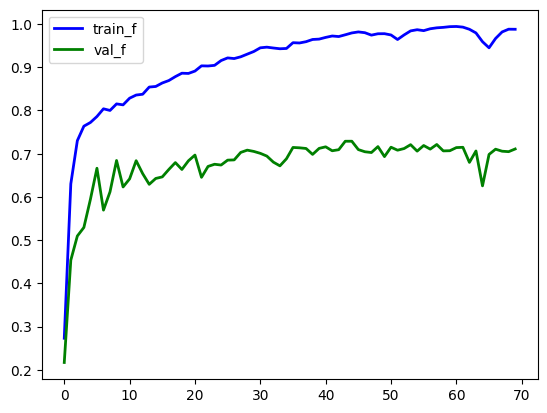

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

# Data
df = pd.DataFrame({'epochs': range(0,len(train_f)), 
                  'train_f': train_f, 
                   'val_f': dev_f})
 
# multiple line plot
plt.plot('epochs', 'train_f', data=df, color='blue', linewidth=2)
plt.plot('epochs', 'val_f', data=df, color='green', linewidth=2)
plt.legend()
plt.show()


In [19]:
%load_ext tensorboard

In [20]:
OUTPUT_PATH = "model_saves/bilstmtagger"

In [21]:
tagger = torch.load(OUTPUT_PATH)
tagger.eval()

BiLSTMTagger(
  (embeddings): Embedding(6853, 300)
  (lstm): LSTM(300, 256, bidirectional=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (hidden2tag): Linear(in_features=512, out_features=6, bias=True)
)

In [22]:
labels = label_field.vocab.itos[2:]
labels = sorted(labels, key=lambda x: x.split("-")[-1])
label_idxs = [label_field.vocab.stoi[l] for l in labels]

test(tagger, test_iter, BATCH_SIZE, labels = label_idxs, target_names = labels)

              precision    recall  f1-score   support

        B-AC       0.61      0.64      0.62       270
        I-LF       0.64      0.74      0.69       288
        B-LF       0.53      0.53      0.53       150
         B-O       0.96      0.94      0.95      4292

    accuracy                           0.90      5000
   macro avg       0.68      0.71      0.70      5000
weighted avg       0.91      0.90      0.90      5000



In [23]:
from colorama import Back, Style

def vizu(words, output, truth):
    if isinstance(output, torch.Tensor):
        output = output.squeeze().tolist()
    col = {0: Back.GREEN, 1: Back.RED, 2: Back.BLACK, 3: Back.BLUE, 4: Back.MAGENTA}
    colors1 = [col[i] for i in output]
    colors2 = [col[i] for i in truth]
    words = [word.replace("Ġ", "") for word in words]
    print(Style.RESET_ALL + "Output:")
    for i, word in enumerate(words):
        print(colors1[i] + word, end=" ")
    print(Style.RESET_ALL + "\nTruth:")
    for i, word in enumerate(words):
        print(colors2[i] + word, end=" ")